# K-Nearest Neighbours – Challenge: Glass Type Classification

## Overview

In this notebook, we will walk through a simple example of k-Nearest Neighbours (k-NN) classification using the Glass Identification dataset. No prior knowledge of k-NN is assumed. We will:
- Introduce the concept of k-NN classification
- Load and inspect the Glass.csv data (refractive index and oxide concentrations)
- Visualize relationships between chemical features and glass type
- Prepare the data (feature scaling, train/test split) and train a k-NN classifier
- Evaluate model performance (accuracy, confusion matrix, ROC-AUC) and interpret the results
  
**Our Goal:** Can we accurately predict a glass sample's type based solely on its chemical composition?

## About the Dataset

**Data Source:** [Glass Identification Dataset from Kaggle](https://www.kaggle.com/datasets/uciml/glass)

This is a famous dataset from the UCI Machine Learning Repository, originally created for forensic glass analysis. Imagine you're a forensic scientist who finds glass fragments at a crime scene - this model could help identify what type of glass it came from!

### Dataset Context
- **Total samples:** 214 glass samples
- **Features:** 9 chemical measurements (like sodium, magnesium, etc.)
- **Target:** Glass type (7 different categories)
- **Real-world application:** Forensic analysis, quality control in glass manufacturing

### Glass Types in Our Dataset:
1. **Building windows (float processed)** 
2. **Building windows (non-float processed)** 
3. **Vehicle windows (float processed)**
4. **Vehicle windows (non-float processed)** - None in this database
5. **Containers** 
6. **Tableware**
7. **Headlamps**

## What is K-Nearest Neighbours (k-NN)?

Think of k-NN like asking your neighbours for advice! Here's how it works:

1. **The Idea:** Similar things should have similar characteristics
2. **How it works:** When we want to classify a new glass sample, we look at the 'k' most similar samples we've seen before
3. **Making predictions:** We take a "vote" from these k neighbors - whatever type most of them are, that's our prediction

**Example:** If k=5 and we find the 5 most similar glass samples, and 3 of them are "building windows" while 2 are "containers", we'd predict "building windows"

**Why k-NN is great for beginners:**
- Very easy to understand
- No complex math or training process

**Additional Learning Resources:**
- [StatQuest: K-nearest neighors, Clearly Explained](https://www.youtube.com/watch?v=HVXime0nQeI&t=21s&pp=ygULd2hhdCBpcyBrbm4%3D)

## Step 1: Loading and Exploring Our Data

Before we can build any machine learning model, we need to understand our data. In this step, we will:

1. **Load the dataset** from a CSV file using pandas (a popular Python library for data analysis)
2. **Check the shape** - How many samples and features do we have?
3. **Look at the distribution** - How many samples of each glass type?
4. **Preview the data** - What do the actual measurements look like?

### Understanding the Data Structure

Our dataset contains **9 chemical measurements** for each glass sample:

| Feature | Full Name | Description | Units |
|---------|-----------|-------------|-------|
| **RI** | Refractive Index | How much light bends when passing through the glass | Dimensionless |
| **Na** | Sodium | Amount of sodium oxide | Weight % |
| **Mg** | Magnesium | Amount of magnesium oxide | Weight % |
| **Al** | Aluminum | Amount of aluminum oxide | Weight % |
| **Si** | Silicon | Amount of silicon dioxide (main glass component) | Weight % |
| **K** | Potassium | Amount of potassium oxide | Weight % |
| **Ca** | Calcium | Amount of calcium oxide | Weight % |
| **Ba** | Barium | Amount of barium oxide | Weight % |
| **Fe** | Iron | Amount of iron oxide | Weight % |

**Target Variable:** `Type` - The type of glass (1, 2, 3, 5, 6, or 7)

### 💡 Learning Lightbulb
**What Are Predictors and Target Variables?**
- Predictor Variables (also called features, independent variables, or inputs) are the measurable properties or characteristics used to make predictions.
  - In our case, these are the 9 chemical measurements like RI, Na, Mg, etc.
- Target Variable (also known as label, dependent variable, or output) is what we're trying to predict or classify.
  - Here, the target is Type, the category of glass.

Let's get into our first line of code!

In [1]:
import pandas as pd

# Load the CSV into a pandas dataframe
df = pd.read_csv('Data/glass.csv')

# Display shape and class distribution
print("Dataset shape:", df.shape)
print("\nGlass type counts:")

# Print the count of each glass type, sorted by index
print(df['Type'].value_counts().sort_index())

# Peek at first rows
df.head()

Dataset shape: (214, 10)

Glass type counts:
Type
1    70
2    76
3    17
5    13
6     9
7    29
Name: count, dtype: int64


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


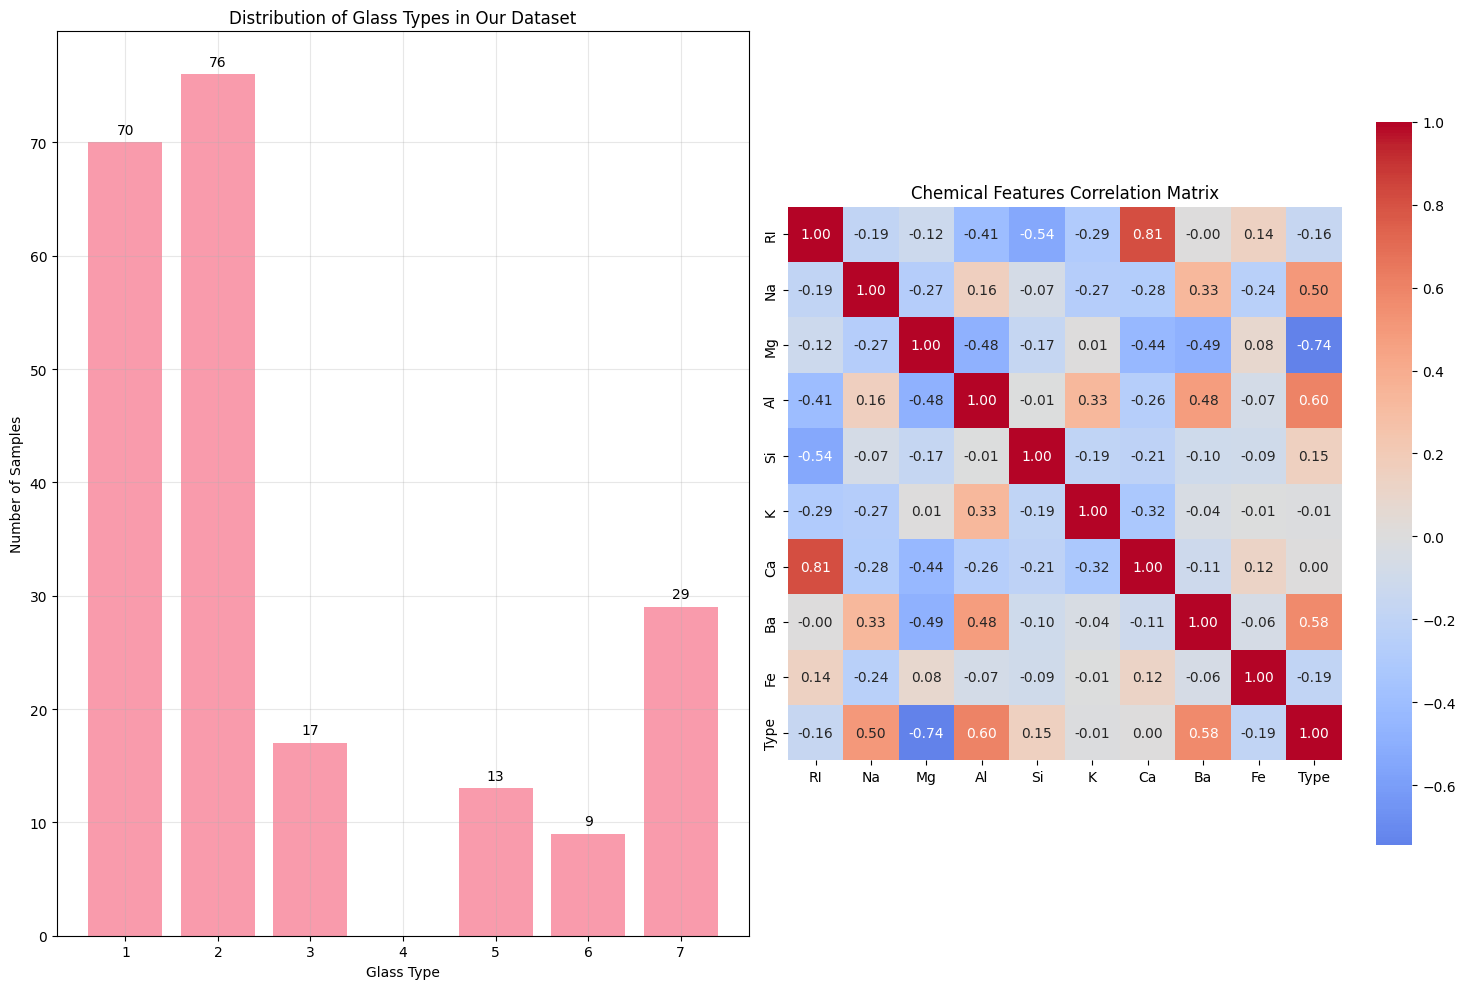

Key Observations from Our Data:
• Most common glass type: Type 2 (76 samples)
• Least common glass type: Type 6 (9 samples)
• Note: Type 4 (vehicle windows non-float) has 0 samples in this dataset
• Dataset is imbalanced - we have many more building windows than other types


In [12]:
# Let's visualise the data to better understand it
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# 1. Distribution of glass types
ax1 = axes[0] 
type_counts = df['Type'].value_counts().sort_index()
bars = ax1.bar(type_counts.index, type_counts.values, alpha=0.7)
ax1.set_xlabel('Glass Type')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Distribution of Glass Types in Our Dataset')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

# 2. Correlation heatmap of chemical features
ax3 = axes[1]  
# Select only numeric columns (exclude Type)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', ax=ax3, cbar_kws={'shrink': 0.8})
ax3.set_title('Chemical Features Correlation Matrix')

plt.tight_layout()
plt.show()

# Print some key observations
print("Key Observations from Our Data:")
print(f"• Most common glass type: Type {type_counts.idxmax()} ({type_counts.max()} samples)")
print(f"• Least common glass type: Type {type_counts.idxmin()} ({type_counts.min()} samples)")
print(f"• Note: Type 4 (vehicle windows non-float) has 0 samples in this dataset")
print(f"• Dataset is imbalanced - we have many more building windows than other types")

## Step 2: Preparing Our Data for Machine Learning

Before we can use k-NN, we need to prepare our data. This step is crucial for getting good results. **"Garbage in, garbage out"** implies that if the input data is poor or flawed, the results will also be unreliable

### Why Do We Need Data Preprocessing?

1. **Separate Features from Labels**: We need to split our data into:
   - **X (features)**: The chemical measurements we'll use to make predictions
   - **y (labels)**: The glass types we want to predict

2. **Scale the Features**: This is **VERY IMPORTANT** for k-NN! Here's why:
   - k-NN calculates distances between data points
   - Features have different units (e.g., RI is around 1.5, while Si is around 70)
   - Without scaling, features with larger values would dominate the distance calculation
   - **StandardScaler** transforms each feature to have mean=0 and standard deviation=1

### What is StandardScaler?

Think of it like converting different units to a common scale:
- **Before scaling**: RI ranges from 1.51-1.53, but Si ranges from 69-76
- **After scaling**: Both features will be centered around 0 with similar ranges

This ensures that all features contribute equally to the distance calculations in k-NN.

In [14]:
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = df.drop('Type', axis=1)
y = df['Type']

# Standardize features for KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Step 3: Splitting Our Data - Train vs Test

Now we need to split our data into two parts. This is a fundamental concept in machine learning!

### Why Split the Data?
- **Training data**: This is the portion of the data the model learns from.
It sees the inputs (features) and the correct outputs (labels) and adjusts itself to reduce error
- **Test data**: This is the data the model has never seen before.
We use it to evaluate performance and check how well the model might perform in the real world

### Our Split Strategy:

- **70% for training** (149 samples): We'll use this to "teach" our k-NN model
- **30% for testing** (65 samples): We'll use this to evaluate how well our model performs on new, unseen data

Split strategy may varied. 80/20 split is also common

### Key Parameters Explained:

- **`test_size=0.3`**: Use 30% of data for testing
- **`stratify=y`**: Keep the same proportion of each glass type in both train and test sets
  - This is important because our dataset is imbalanced (more building windows than headlamps)
  - Stratification ensures we have representative samples of each type in both sets
- **`random_state=42`**: Makes our split reproducible (same results every time we run this code)

This split allows us to train our model on one set of data and test it on completely different data, giving us an honest assessment of how well it will perform in the real world!

In [16]:
from sklearn.model_selection import train_test_split

# 70% train, 30% test, stratified by glass type
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

print("Train set size:", X_train.shape[0])
print("Test set size: ", X_test.shape[0])

Train set size: 149
Test set size:  65


## Step 4: Finding the Best k Value - Hyperparameter Tuning

The most important decision in k-NN is choosing the right value of k (number of neighbors). This is called **hyperparameter tuning**.

### How Do We Choose k?

We'll test different values of k (from 1 to 20) and see which one gives us the best performance. But here's the key: we can't use our test set for this (remember, that's our "final exam"!).

### Cross-Validation: A Smart Way to Test

Instead, we'll use **5-fold cross-validation** on our training data:

1. **Split training data into 5 parts** (called "folds")
2. **For each k value:**
   - Train on 4 folds, test on the remaining 1 fold
   - Repeat this 5 times (each fold gets to be the test fold once)
   - Average the 5 accuracy scores

### Key Parameters Explained:

- **`n_neighbors=k`**: The number of neighbors to consider
- **`cv=5`**: Use 5-fold cross-validation
- **`scoring='accuracy'`**: Measure how often we predict the correct glass type

### What to Expect:

- **k=1**: Might overfit (too sensitive to individual training examples)
- **k too large**: Might underfit (considers too many neighbors, loses local patterns)
- **Best k**: Usually somewhere in between

Let's find our optimal k value!

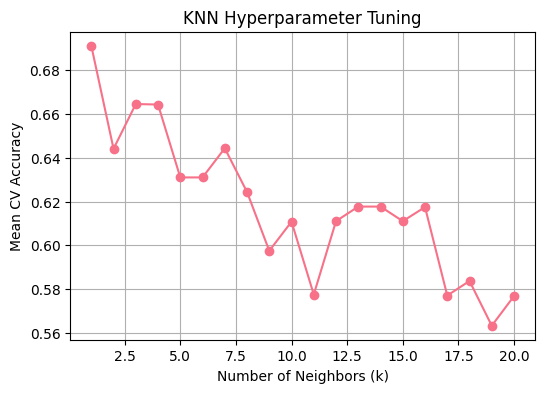

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Try k from 1 to 20
k_values = list(range(1, 21))
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot accuracy vs k
plt.figure(figsize=(6,4))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV Accuracy')
plt.title('KNN Hyperparameter Tuning')
plt.grid(True)
plt.show()


In [20]:
# Build a table of CV results
cv_results = pd.DataFrame({
    'k': k_values,
    'CV Mean Accuracy': cv_scores
}).set_index('k')
cv_results


,CV Mean Accuracy
k,
1,0.691264
2,0.644138
3,0.664598
4,0.664368
5,0.631034
6,0.631034
7,0.644368
8,0.624368
9,0.597471


## Step 5: Training Our Final Model and Evaluation

Now it's time for the final test! We'll use the best k value we found and train our model on all the training data, then see how well it performs on our test set.

### What We'll Do:

1. **Select the best k**: Choose the k value with the highest cross-validation accuracy
2. **Train the final model**: Use this k to train on our entire training set
3. **Make predictions**: Test our model on the unseen test data
4. **Evaluate performance**: Look at detailed metrics to understand how well we did

### Understanding the Classification Report:

![Precision and Recall](../Assets/precision_recall.png)

Image Source: [Why Accuracy Can Be Deceptive - A Product Manager's Guide to Recall](https://www.linkedin.com/pulse/why-accuracy-can-deceptive-product-managers-guide-recall-prasmit-quxhc)

The classification report will show us several important metrics for each glass type:

- **Precision**: Of all the samples we predicted as type X, how many were actually type X?
  - Example: If we predicted 10 samples as "headlamps" but only 8 were actually headlamps, precision = 8/10 = 80%
  
- **Recall**: Of all the actual type X samples, how many did we correctly identify?
  - Example: If there were 10 actual headlamps and we found 8 of them, recall = 8/10 = 80%
  
- **F1-score**: The harmonic mean of precision and recall (balances both metrics)

- **Support**: How many samples of this type were in our test set

### Overall Metrics:

- **Accuracy**: Overall percentage of correct predictions
- **Macro avg**: Average metrics across all glass types (treats each type equally)
- **Weighted avg**: Average metrics weighted by the number of samples per type

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Select k with highest CV accuracy
best_k = int(cv_results['CV Mean Accuracy'].idxmax())
print("Optimal k:", best_k)

# Train on full train set
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

# Predict on test set
y_pred = knn_final.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))


Optimal k: 1
              precision    recall  f1-score   support

           1       0.84      0.76      0.80        21
           2       0.76      0.83      0.79        23
           3       0.50      0.40      0.44         5
           5       0.80      1.00      0.89         4
           6       0.67      0.67      0.67         3
           7       1.00      1.00      1.00         9

    accuracy                           0.80        65
   macro avg       0.76      0.78      0.77        65
weighted avg       0.80      0.80      0.80        65



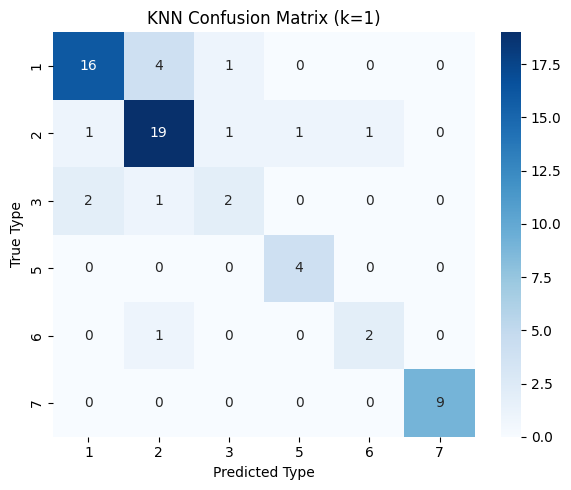

In [22]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn_final.classes_)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=knn_final.classes_,
            yticklabels=knn_final.classes_)
plt.xlabel('Predicted Type')
plt.ylabel('True Type')
plt.title('KNN Confusion Matrix (k={})'.format(best_k))
plt.tight_layout()
plt.show()


## Step 6: Understanding Our Model's Mistakes - Confusion Matrix

A confusion matrix is like a detailed report card that shows us exactly where our model gets confused!

### How to Read a Confusion Matrix:

- **Rows**: The true (actual) glass types
- **Columns**: The predicted glass types  
- **Diagonal values**: Correct predictions (these should be high!)
- **Off-diagonal values**: Mistakes (we want these to be low)

### What to Look For:

- **Perfect predictions**: High numbers on the diagonal
- **Common mistakes**: Large numbers off the diagonal
- **Class-specific performance**: Some glass types might be harder to predict than others

### Why This Matters:

Understanding where our model makes mistakes helps us:
- Identify which glass types are most difficult to classify
- See if certain types are commonly confused with each other
- Decide if our model is good enough for real-world use

For example, if our model often confuses "building windows (float processed)" with "building windows (non-float processed)", Type 1 and Type 2 respectively, that might be acceptable since they're chemically similar. But confusing "containers" with "headlamps" might be more problematic!